# Roads: Rasters to Vectors

This notebook demonstrates the process of converting an output of the [Analytics Feed](https://developers.planet.com/docs/analytics/) (road footprint raster) into a vector dataset, using the following steps:

1. Obtaining An Analytics Raster
2. Downloading Quad Raster
3. Visualizing Road Image
4. Converting Roads Raster to Vector Features using the following techniques:
    * [GDAL CLI](https://automating-gis-processes.github.io/2016/Lesson7-gdal-utilities.html)
    * [Rasterio](https://rasterio.readthedocs.io/en/stable/) (no processing)
    * Rasterio (with simplification)
    * Rasterio (flexible function, filtering and simplification as example)

Open this notebook in Colab below:

<a target="_blank" href="https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/analytics-snippets/raster_to_vector_roads.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Import packages:

In [1]:
import json
import os
import requests
import fiona
import matplotlib.pyplot as plt
from planet import Auth

from planet import Session, DataClient, OrdersClient
import rasterio
from rasterio import features as rfeatures
from rasterio.enums import Resampling
from rasterio.plot import show
import shapely
from shapely.geometry import shape as sshape
from shapely import affinity

## Set up API Key:

Ensure you have a Planet API Key which you can find [here](https://www.planet.com/account/#/user-settings).

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_API_KEY_HERE')

client = Auth.from_key(API_KEY)

# Use our API key as the basic authentication username
apiAuth = (API_KEY, '')

## Obtain Analytics Raster

### Identify road feed feature for download

We want to download the most recent feature from the feed for road detection in Kirazli, Turkey.

In [3]:
# This ID is for a subscription for monthly road detection in Kirazli, Turkey
subscription_id = 'f184516c-b948-406f-b257-deaa66c3f38a'

In [4]:
# Planet Analytics API base url
PAA_BASE_URL = "https://api.planet.com/analytics/"

# Define collections endpoint
collections_endpoint = 'collections/'

# Construct the URL for the HTTP request 
# (Planet Analytics API base URL + desired endpoint)
collections_request_url = PAA_BASE_URL + collections_endpoint

In [5]:
# Request Collection Items
# We're interested in the items in the collection

# Construct the URL for the subscription's Results Collection
collection_results_url = collections_request_url + subscription_id + '/' + 'items'

print("Request URL: {}".format(collection_results_url))

# Get subscription results collection
collection_items = requests.get(collection_results_url, auth=apiAuth).json()

# Pretty Print response JSON
print(json.dumps(collection_items, sort_keys=True, indent=4))

Request URL: https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items
{
    "features": [
        {
            "created": "2019-10-11T23:47:27.690Z",
            "geometry": {
                "coordinates": [
                    [
                        [
                            26.7187499963,
                            40.04443758
                        ],
                        [
                            26.7187499963,
                            40.1788733097
                        ],
                        [
                            26.5429687464,
                            40.1788733097
                        ],
                        [
                            26.5429687464,
                            40.04443758
                        ],
                        [
                            26.7187499963,
                            40.04443758
                        ]
                    ]
                ],
             

In [6]:
# How many features do we have in this collection?

features = collection_items['features']
print('{} features in collection'.format(len(features)))

96 features in collection


In [7]:
# sort features by acquisition date and take latest feature

features.sort(key=lambda k: k['properties']['first_acquired'])
feature = features[-1]

print (feature)

print(feature['properties']['first_acquired'])

{'created': '2019-10-11T22:30:38.045Z', 'geometry': {'type': 'Polygon', 'coordinates': [[[26.8945312463, 39.9097362299], [26.8945312463, 40.04443758], [26.7187499963, 40.04443758], [26.7187499963, 39.9097362299], [26.8945312463, 39.9097362299]]]}, 'id': 'afb9e074-b180-4e11-9524-eb9bd4def5c5', 'links': [{'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e074-b180-4e11-9524-eb9bd4def5c5', 'rel': 'self', 'type': 'application/geo+json'}, {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e074-b180-4e11-9524-eb9bd4def5c5/resources/source-quad', 'rel': 'source-quad', 'type': 'image/tiff'}, {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2019_07_mosaic/gmap/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7', 'rel': 'source-tiles', 'type': 'image/png'}, {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e0

### Download Quad Raster

In [8]:
feature_links = feature['links']
feature_links

[{'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e074-b180-4e11-9524-eb9bd4def5c5',
  'rel': 'self',
  'type': 'application/geo+json'},
 {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e074-b180-4e11-9524-eb9bd4def5c5/resources/source-quad',
  'rel': 'source-quad',
  'type': 'image/tiff'},
 {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2019_07_mosaic/gmap/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7',
  'rel': 'source-tiles',
  'type': 'image/png'},
 {'href': 'https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e074-b180-4e11-9524-eb9bd4def5c5/resources/target-quad',
  'rel': 'target-quad',
  'type': 'image/tiff'},
 {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/sif-36d9d1b0-dcd4-40bc-b411-5eb8e06062a2-2019-07-01/gmap/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7',
  '

In [9]:
# Construct the URL to target quad
target_quad = list(filter(lambda link: link['rel'] == 'target-quad', feature_links))[0]['href']

print("Target (Result) Quad URL:\n{}\n".format(target_quad))

Target (Result) Quad URL:
https://api.planet.com/analytics/collections/f184516c-b948-406f-b257-deaa66c3f38a/items/afb9e074-b180-4e11-9524-eb9bd4def5c5/resources/target-quad



Clicking the link in the above cell will download the COG (.tiff) file!

### Visualize Roads Image

The output of the analytics road detection is a boolean image where road pixels are given a value of True and non-road pixels are given a value of False.

In [10]:
# Set filepaths for target quad (raster), and folder where you'd like our vector files to be downloaded
filename = "INSERT FILENAME HERE"
dest = "INSERT FILE DESTINATION HERE"

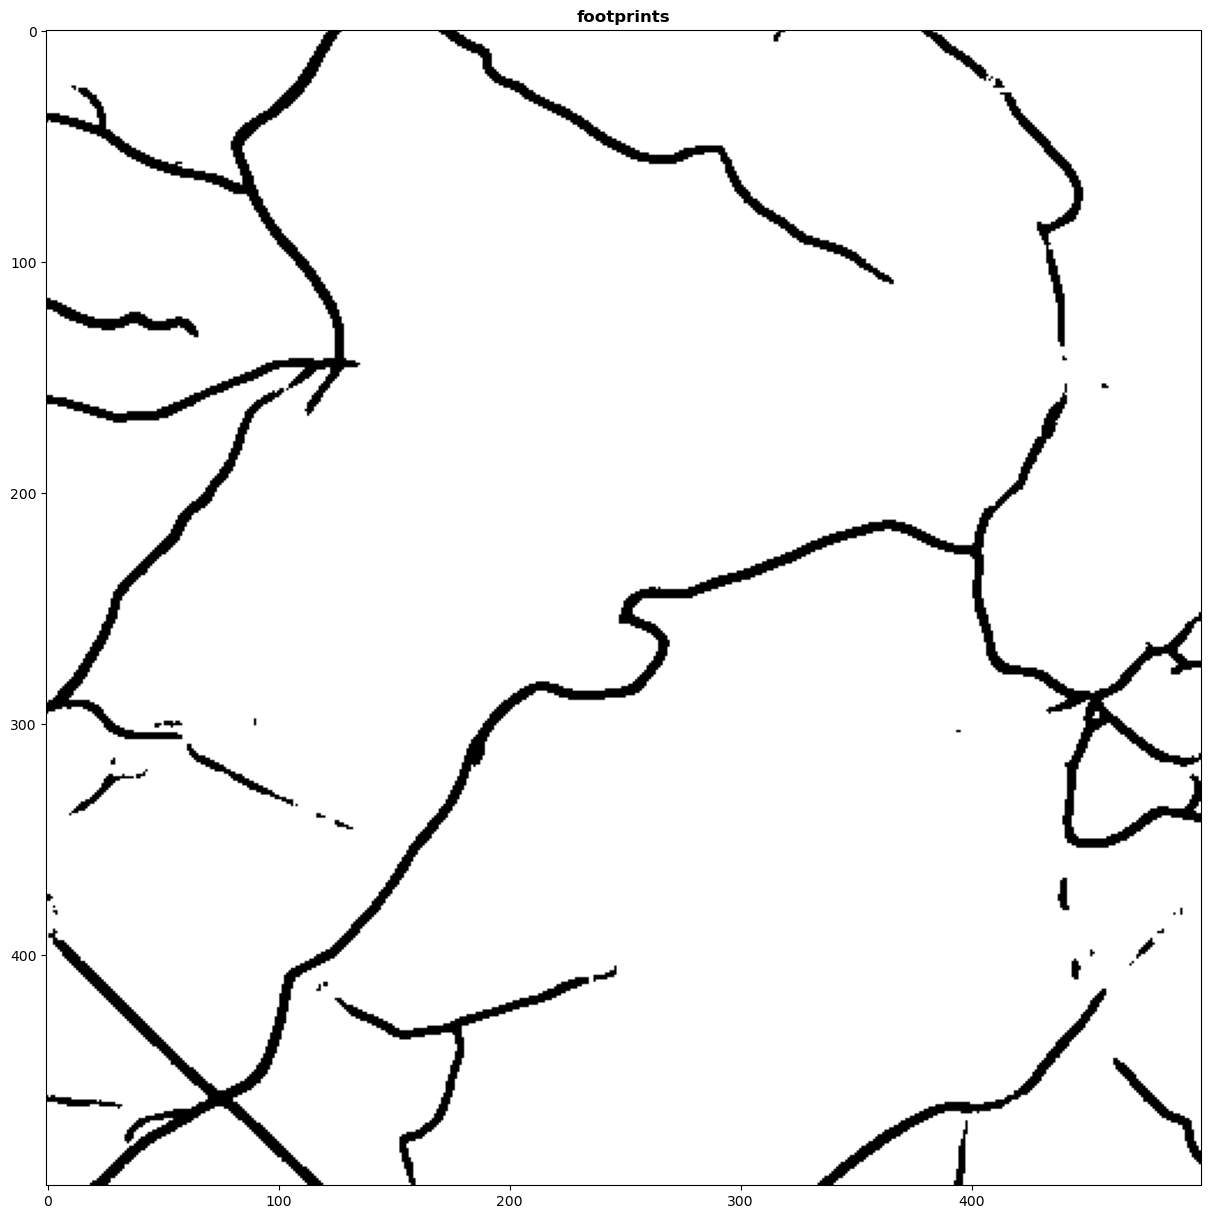

<AxesSubplot:title={'center':'footprints'}>

In [11]:
def _open(filepath, factor=1):
    """
    Opens a raster file using rasterio and reads its data.

    Parameters:
        filename (str): The path to the raster file to be opened.
        factor (int, optional): A factor by which the height and width of the raster data will be reduced.
                                Default is 1, meaning no reduction.

    Returns:
        numpy.ndarray: A NumPy array containing the raster data after applying the reduction factor.
    """
    with rasterio.open(filepath) as dataset:
        height = int(dataset.height / factor)
        width = int(dataset.width / factor)
        data = dataset.read(
            out_shape=(dataset.count, height, width)
        )
    return data

def open_bool(filepath, factor=1):
    """
    Opens a raster file and returns its first band as a binary array. This function is a wrapper around the _open function, 
    which reads the raster file and applies any reduction factor specified. 
    The first band of the raster data is extracted, which is typically used to represent boolean data.

    Parameters:
        filename (str): The path to the raster file to be opened.
        factor (int, optional): A factor by which the height and width of the raster data will be reduced.
                                Default is 1, meaning no reduction.

    Returns:
        numpy.ndarray: A NumPy array containing the boolean raster data after applying the reduction factor.
                       The array represents the first band of the raster data.
    """
    data = _open(filepath, factor=factor)
    return data[0,:,:]

def get_figsize(factor):
    """
    Calculates the figure size for plotting based on a given reduction factor. 
    The figure size is calculated as a tuple of two integers, representing the width and height of the figure.

    Parameters:
        factor (int): The reduction factor used for opening raster data.

    Returns:
        tuple: A tuple of two integers representing the width and height of the figure size.
    """
    return tuple(2 * [int(25/factor)])


factor = 1
figsize = (15, 15)

roads = open_bool(filename, factor=factor)
fig = plt.figure(figsize=figsize)
# show(roads, title="footprints", cmap="binary")
show(roads[2500:3000, 0:500], title="footprints", cmap="binary")

## Convert Roads to Vector Features

### GDAL Command-Line Interface (CLI)

GDAL provides a python script that can be run via the CLI. It is quite easy to run and fast, though it doesn't allow for some of the convenient pixel-space filtering and processing that rasterio provides and we will use later on.

In [12]:
def get_layer_name(filepath):
    """
    This function derives the layer name from a given filename. The layer name 
    is considered as the part of the filename that comes before the first '.' character. 

    Note that the function assumes that the filename is provided in the form of a path, and that 
    the layer name does not contain any '.' characters.

    Args:
    filename (str): The path of the file from which to derive the layer name.

    Returns:
    str: The derived layer name.
    """
    return filepath.split('/')[-1].split('.')[0]

gdal_tmp_output_filename = os.path.join(dest, 'test_gdal_all.shp')
gdal_tmp_output_layer_name = get_layer_name(gdal_tmp_output_filename)
gdal_output_filename = os.path.join(dest, 'test_gdal.shp')
gdal_output_layer_name = get_layer_name(gdal_output_filename)

In [13]:
# convert the binary image into polygons
# creates polygons for road footprints as well as regions between
# and around road footprints
!gdal_polygonize.py $filepath $gdal_tmp_output_filename

usage: gdal_polygonize.py [-h] [-q] [-8] [-o name=value] [-mask filename]
                          [-nomask] [-b band] [-of ogr_format]
                          [-lco name=value]
                          src_filename dst_filename [dst_layername]
                          [dst_fieldname]
gdal_polygonize.py: error: the following arguments are required: src_filename, dst_filename


In [14]:
# get number of features, this includes inside and outside road footprints
!ogrinfo -so  $gdal_tmp_output_filename $gdal_tmp_output_layer_name | grep 'Feature Count'

Feature Count: 1982


In [15]:
# get number of road footprint features
# road footprints are associated with image value (DN) of 255
!ogrinfo -so $gdal_tmp_output_filename -sql "SELECT * FROM $gdal_tmp_output_layer_name WHERE DN=255" \
    | grep 'Feature Count'

Feature Count: 1675


In [16]:
# create a new shapefile with only road footprints
!ogr2ogr -sql "SELECT * FROM $gdal_tmp_output_layer_name WHERE DN=255" \
    $gdal_output_filename $gdal_tmp_output_filename

In [17]:
# confirm the number of road footprint features
!ogrinfo -so $gdal_output_filename -sql "SELECT * FROM $gdal_output_layer_name WHERE DN=255" \
    | grep 'Feature Count'

Feature Count: 1675


### Rasterio - no filtering

In this section we use rasterio to convert the binary roads raster into a vector dataset. The vectors are written to disk as a shapefile. The shapefile can be imported into geospatial programs such as QGIS or ArcGIS for visualization and further processing.

This is basic conversion to vector shapes. No filtering based on size (useful for removing small 1 or 2 pixel road segments), smoothing to remove pixel edges, or conversion to the road centerlines is performed here. These additional 'features' will be provided in sections below this one in the future.

In [18]:
def roads_as_vectors(filepath): 
    """
    This function reads road data from a raster file, applies a mask to non-road pixels, 
    and transforms the road data into image CRS (Coordinate Reference System) using the transformation information 
    from the raster file.

    Args:
    filename (str): The path of the raster file to read the data from.

    Returns:
    tuple: A tuple containing the transformed road geometries and the CRS of the dataset.
    """
    with rasterio.open(filepath) as dataset:
        roads = dataset.read(1)
        road_mask = roads == 255 # mask non-road pixels

        # transforms roads features to image crs
        road_shapes = rfeatures.shapes(roads, mask=road_mask, connectivity=8, transform=dataset.transform)
        road_geometries = (r for r, _ in road_shapes)
        
        crs = dataset.crs
    return (road_geometries, crs)

def save_as_shapefile(output_filename, geometries, crs):
    """
    This function saves the provided geometries into a shapefile.

    Args:
    output_filename (str): The path of the output shapefile.
    geometries (iterable): The geometries to write into the shapefile.
    crs (CRS): The Coordinate Reference System to use for the shapefile.

    """
    driver='ESRI Shapefile'
    schema = {'geometry': 'Polygon', 'properties': []}
    with fiona.open(output_filename, mode='w', driver=driver, schema=schema, crs=crs) as c:
        count = 0
        for g in geometries:
            count += 1;
            c.write({'geometry': g, 'properties': {}})
        print('wrote {} geometries to {}'.format(count, output_filename))

        
road_geometries, crs = roads_as_vectors(filename)
output_filename = os.path.join(dest, 'test.shp')
save_as_shapefile(output_filename, road_geometries, crs)

wrote 1507 geometries to /Users/em.steuer/Downloads/test.shp


### Rasterio - Filtering and Simplifying

In this section, we use `shapely` to filter the road vectors by size and simplify them so we don't have a million pixel edges.

In [19]:
def roads_as_vectors_with_filtering(filepath, min_pixel_size=5): 
    """
    This function reads road data from a raster file, applies a mask to non-road pixels,
    simplifies the geometries in the pixel space, and then transforms them to image CRS (Coordinate Reference System). 
    During the simplification process, it skips the transform operation on vectorization and applies 
    a simplification tolerance to avoid too many pixel edge points. It then transforms the simplified shapes 
    to the CRS of the dataset. 

    Args:
    filename (str): The path of the raster file to read the data from.

    Returns:
    tuple: A tuple containing the simplified and transformed road geometries and the CRS of the dataset.
    """
    with rasterio.open(filepath) as dataset:
        roads = dataset.read(1)
        road_mask = roads == 255 # mask non-road pixels

        # we skip transform on vectorization so we can perform filtering in pixel space
        road_shapes = rfeatures.shapes(roads, mask=road_mask, connectivity=8)
        road_geometries = (r for r, _ in road_shapes)
        geo_shapes = (sshape(g) for g in road_geometries)

        # filter to shapes bigger than min_pixel_size
        geo_shapes = (s for s in geo_shapes if s.area > min_pixel_size)
    
        # simplify so we don't have a million pixel edge points
        tolerance = 1 #1.5
        geo_shapes = (g.simplify(tolerance, preserve_topology=False)
                      for g in geo_shapes)

        # apply image transform    
        # rasterio transform: (a, b, c, d, e, f, 0, 0, 1), c and f are offsets
        # shapely: a b d e c/xoff f/yoff
        d = dataset.transform
        shapely_transform = [d[0], d[1], d[3], d[4], d[2], d[5]]
        proj_shapes = (shapely.affinity.affine_transform(g, shapely_transform)
                       for g in geo_shapes)
        
        road_geometries = (shapely.geometry.mapping(s) for s in proj_shapes)
        
        crs = dataset.crs
    return (road_geometries, crs)

In [20]:
road_geometries_filt, crs = roads_as_vectors_with_filtering(filename)
output_filename = os.path.join(dest, 'test_filt.shp')
save_as_shapefile(output_filename, road_geometries_filt, crs)

wrote 844 geometries to /Users/em.steuer/Downloads/test_filt.shp
